# Final Project

In [1]:
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd

sc = SparkContext.getOrCreate()

import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.ml.feature import StringIndexer



spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Final Project") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

In [2]:
#read in data
path_to_data=os.path.join('data/Hotel_Reviews.csv')
df=spark.read.csv(path_to_data,header=True,inferSchema = True)

In [3]:
top_nation_count = 30
group_nation = df.groupBy("Reviewer_Nationality").count().orderBy(col("count").desc()).limit(top_nation_count)
group_nation_top = group_nation.select('Reviewer_Nationality').rdd.flatMap(lambda x: x).collect()
df2 = df.filter(df.Reviewer_Nationality.isin(group_nation_top))
df3=df2.select("Reviewer_Nationality","Reviewer_Score")

In [4]:
import pyspark.sql.functions as F
agg_df = df3.groupBy("Reviewer_Nationality").agg(F.avg("Reviewer_Score"))


In [5]:
from matplotlib import pyplot 

#Add values to a list (not recommend when you have a huge dataframe)
bla = agg_df.collect()
#create a numeric value for every label
indexes = list(range(len(bla)))

#split words and counts to different lists 
values = [r['avg(Reviewer_Score)'] for r in bla]
labels = [r['Reviewer_Nationality'] for r in bla]

#Plotting
bar_width = 0

pyplot.bar(indexes, values)

#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels, fontsize=8)
pyplot.xlabel("Nations")
pyplot.ylabel("Average Score")
pyplot.show()

<Figure size 640x480 with 1 Axes>

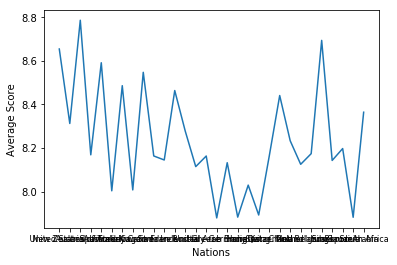

In [6]:
pyplot.plot(indexes, values)

#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels, fontsize=8)
pyplot.xlabel("Nations")
pyplot.ylabel("Average Score")
pyplot.show()

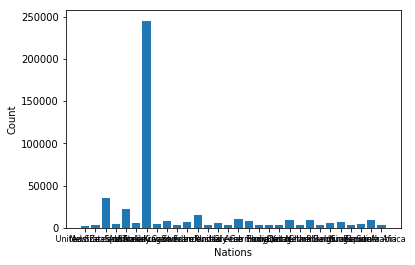

In [7]:
feature_group = ['Reviewer_Nationality']
data_counts = df3.groupBy(feature_group).count().alias("counts")
data_joined = df3.join(data_counts, feature_group)
data_joined2=data_joined.groupBy("Reviewer_Nationality").agg(F.avg("count"))
bla2 = data_joined2.collect()
indexes = list(range(len(bla2)))

#split words and counts to different lists 
values = [r['avg(count)'] for r in bla2]
labels = [r['Reviewer_Nationality'] for r in bla2]

#Plotting
bar_width = 0

pyplot.bar(indexes, values)

#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels, fontsize=8)
pyplot.xlabel("Nations")
pyplot.ylabel("Count")
pyplot.show()

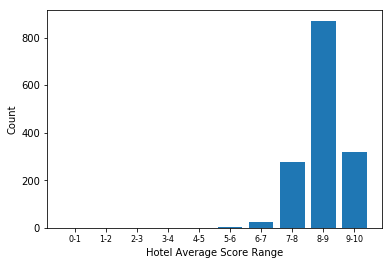

In [8]:
top_nation_count = 50
#group_hotel = df.groupBy("Hotel_Name").count().orderBy(col("count").desc()).limit(top_nation_count)
group_hotel = df.groupBy("Hotel_Name").count().orderBy(col("count").desc())
agg_df_hotel = df.groupBy("Hotel_Name").agg(F.avg("Reviewer_Score"))
level1=agg_df_hotel.filter(agg_df_hotel['avg(Reviewer_Score)'] > 9)
l1=level1.count()
level2=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(8,9))
l2=level2.count()
level3=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(7,8))
l3=level3.count()
level4=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(6,7))
l4=level4.count()
level5=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(5,6))
l5=level5.count()
level6=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(4,5))
l6=level6.count()
level7=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(3,4))
l7=level7.count()
level8=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(2,3))
l8=level8.count()
level9=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(1,2))
l9=level9.count()
level10=agg_df_hotel.filter(F.col("avg(Reviewer_Score)").between(0,1))
l10=level10.count()
import pandas as pd
#df_count = pd.DataFrame({'Hotel Range':['0-1','1-2','2-3', '3-4','4-5','5-6','6-7', '7-8','8-9','9-10'], 'Count':[level10,level9,level8,level7,level6,level5,level4,level3,level2,level1]})
df_count = pd.DataFrame({'Hotel Range':['0-1','1-2','2-3', '3-4','4-5','5-6','6-7', '7-8','8-9','9-10'], 'Count':[l10,l9,l8,l7,l6,l5,l4,l3,l2,l1]})
spark_df = sqlCtx.createDataFrame(df_count)
from matplotlib import pyplot 

#Add values to a list (not recommend when you have a huge dataframe)
bla = spark_df.collect()
#create a numeric value for every label
indexes = list(range(len(bla)))

#split words and counts to different lists 
values = [r['Count'] for r in bla]
labels = [r['Hotel Range'] for r in bla]

#Plotting
bar_width = 0

pyplot.bar(indexes, values)

#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels, fontsize=8)
pyplot.xlabel("Hotel Average Score Range")
pyplot.ylabel("Count")
pyplot.show()



In [9]:
###clean data, combine reviews
###pipeline first then split
from pyspark.sql.functions import lit,col
reviews_pos=df.select(['Positive_Review',"Hotel_name"]).withColumnRenamed("Positive_Review", "Review")
reviews_neg=df.select(['Negative_Review',"Hotel_name"]).withColumnRenamed("Negative_Review", "Review")
reviews_pos = reviews_pos.withColumn("label",lit(1)).filter(col("Review") != 'No Positive')
reviews_neg = reviews_neg.withColumn("label",lit(0)).filter(col("Review") != 'No Negative')
reviews_final = reviews_pos.union(reviews_neg)
reviews_final.dropna()
sample1,sample2 = reviews_final.randomSplit([0.005,0.995],seed = 314)#only use test1 for further research

In [10]:
###get word frequency
reviews_raw_text = sample1.select(["Review"]).rdd.flatMap(lambda r: r)
reviews_raw_final = reviews_raw_text.flatMap(lambda r: r.split(" "))\
                                    .filter(lambda r: r != '')\
                                    .map(lambda r: r.lower())
                                                 
reviews_raw_count= reviews_raw_final.map(lambda x: (x, 1)) \
                               .reduceByKey(lambda x,y:x+y) \
                               .map(lambda x:(x[1],x[0])) \
                               .sortByKey(False)

In [11]:
##take top 20
reviews_raw_count.take(20)

[(5226, 'the'),
 (3151, 'and'),
 (2333, 'was'),
 (1991, 'to'),
 (1966, 'a'),
 (1554, 'room'),
 (1400, 'very'),
 (1387, 'in'),
 (1192, 'staff'),
 (1137, 'of'),
 (1068, 'for'),
 (1018, 'location'),
 (1006, 'hotel'),
 (935, 'i'),
 (918, 'is'),
 (802, 'we'),
 (784, 'breakfast'),
 (782, 'it'),
 (778, 'were'),
 (724, 'not')]

In [12]:
reviews_raw_count.count()

5691

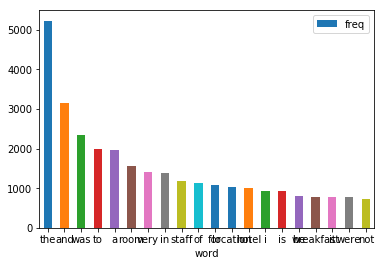

In [13]:
###plot word frequency
review_freq_df = reviews_raw_count.toDF(["freq","word"])
review_freq_df_pandas = review_freq_df.toPandas()
review_freq_df_pandas = review_freq_df_pandas.head(20)
ax = review_freq_df_pandas.plot.bar(x='word', y='freq', rot=0)

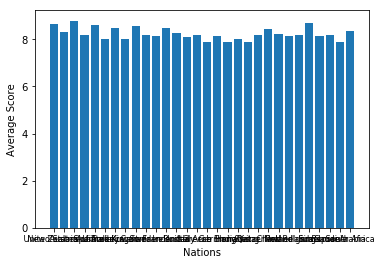

In [14]:
from matplotlib import pyplot 

#Add values to a list (not recommend when you have a huge dataframe)
bla = agg_df.collect()
#create a numeric value for every label
indexes = list(range(len(bla)))

#split words and counts to different lists 
values = [r['avg(Reviewer_Score)'] for r in bla]
labels = [r['Reviewer_Nationality'] for r in bla]

#Plotting
bar_width = 0

pyplot.bar(indexes, values)

#add labels
labelidx = [i + bar_width for i in indexes] 
pyplot.xticks(labelidx, labels, fontsize=8)
pyplot.xlabel("Nations")
pyplot.ylabel("Average Score")
pyplot.show()

In [15]:
#####naive bayes
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Review", outputCol="words", pattern="\\W")
# stop words
stop_words = ["ourselves", "hers", "between", "yourself", "but","again", "there", "about", "once", 
              "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", 
              "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", 
              "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", 
              "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", 
              "her", "more", "himself", "this", "down", "should", "our", "their", "while",  
              "both", "to", "ours", "had", "she", "all", "no", "when", "at", 
              "any", "before", "them", "same", "and", "been", "have", "in", "will", 
              "on", "does", "yourselves", "then", "that", "because", "what", "over", 
              "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", 
              "has", "just", "where", "too", "only", "myself", "which", "those", "i", 
              "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", 
              "a", "by", "doing", "it", "how", "was", "here"] 

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stop_words)
# bag of words count
#countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=5000, minDF=5)

hashtf = HashingTF(numFeatures=5000, inputCol="filtered", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

pipeline = Pipeline(stages=[regexTokenizer,stopwordsRemover, hashtf, idf])



In [16]:
pipelineFit = pipeline.fit(sample1)
#reviews_pipeline= pipelineFit.transform(train_set)
nb_feature_df = pipelineFit.transform(sample1)

In [17]:
temp_train_nb,temp_val_nb = nb_feature_df.randomSplit([0.8,0.2],seed = 314)
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(temp_train_nb)
predictions_nb = nb_model.transform(temp_val_nb)

In [18]:
predictions_nb.show(10)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              Review|          Hotel_name|label|               words|            filtered|                  tf|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| A free bottle of...|Radisson Blu Edwa...|    1|[a, free, bottle,...|[free, bottle, pr...|(5000,[494,1073,1...|(5000,[494,1073,1...|[-276.55120735310...|[9.17615026084336...|       1.0|
| A truly five sta...|        H tel Vernet|    1|[a, truly, five, ...|[truly, five, sta...|(5000,[1,23,170,2...|(5000,[1,23,170,2...|[-756.20502631702...|[3.38625507002275...|       1.0|
| All of it was fa...|Shangri La Hotel ...|    1|[all, of, it, wa

In [19]:
#get accuracy and area under ROC
evaluator = BinaryClassificationEvaluator()
#evaluator = BinaryClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="precision")
auc_nb = evaluator.evaluate(predictions_nb) #default is area under ROC
accuracy_nb = predictions_nb.filter(predictions_nb.label == predictions_nb.prediction).count() / float(temp_val_nb.count())
print ("Model Accuracy: ", accuracy_nb)
print ("Model AUC: ", auc_nb)



Model Accuracy:  0.860981308411215
Model AUC:  0.6161381942441255


In [20]:
##pipeline for cv
nb_cv = NaiveBayes(modelType="multinomial")
pipeline_cv = Pipeline(stages=[nb_cv])
pipelineFit_cv = pipeline_cv.fit(temp_train_nb)

In [21]:
######tuning smoothing parameter by using cv

# Create ParamGrid and Evaluator for Cross Validation
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).build()
cvEvaluator = BinaryClassificationEvaluator()
# Run Cross-validation
cv = CrossValidator(estimator=pipeline_cv, estimatorParamMaps=paramGrid, evaluator=cvEvaluator)
cvModel = cv.fit(temp_train_nb)
# Make predictions on testData. cvModel uses the bestModel.
cvPredictions = cvModel.transform(temp_val_nb)
cvPredictions.select("label", "prediction", "probability")

DataFrame[label: int, prediction: double, probability: vector]

In [22]:
nb_auc_final = evaluator.evaluate(cvPredictions)
nb_accuracy_final = cvPredictions.filter(cvPredictions.label == cvPredictions.prediction).count() / float(temp_val_nb.count())

print ("nb accuracy is", nb_accuracy_final)
print ("nb auc is", nb_auc_final)


nb accuracy is 0.860981308411215
nb auc is 0.6161381942441255


In [23]:
###svm using the same pipeline as previous, use hashingTF, IDF
temp_train_svm = temp_train_nb
temp_val_svm = temp_val_nb

In [24]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import linalg as ml_linalg
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors

def as_mllib(v):
    if isinstance(v, ml_linalg.SparseVector):
        return MLLibVectors.sparse(v.size, v.indices, v.values)
    elif isinstance(v, ml_linalg.DenseVector):
        return MLLibVectors.dense(v.toArray())
    else:
        raise TypeError("Unsupported type: {0}".format(type(v)))


In [25]:
svm_train = temp_train_svm.select(['label','features'])
svm_train_lb = svm_train.rdd.map(lambda r: LabeledPoint(r[0], as_mllib(r[1])))
svm_val = temp_val_svm.select(['label','features'])
svm_val_lb = svm_val.rdd.map(lambda r: LabeledPoint(r[0], as_mllib(r[1])))

In [26]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
# Build the model
svm_model = SVMWithSGD.train(svm_train_lb, iterations=100)

In [27]:
# Evaluating the model on test data
labelsAndPreds = svm_val_lb.map(lambda p: (p.label, svm_model.predict(p.features)))
svm_accuracy = labelsAndPreds.filter(lambda r: r[0] == r[1]).count() / float(svm_train_lb.count())
svm_predictions = sqlCtx.createDataFrame(labelsAndPreds, ['label','rawPrediction'])
#avm_auc = evaluator.evaluate(svm_predictions)
print("SVM accuracy = " + str(svm_accuracy))
#print("SVM auc = " + str(avm_auc))

SVM accuracy = 0.2180987724807308


In [28]:
##### logistic regression with tokenizer, stopwords, hashingTF, IDF
###use the same pipeline as previous
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=100)
lr_model = lr.fit(temp_train_nb)
predictions_lr = lr_model.transform(temp_val_nb)

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
auc_lr = evaluator.evaluate(predictions_lr)
accuracy_lr = predictions_lr.filter(predictions_lr.label == predictions_lr.prediction).count() / float(temp_val_nb.count())
print ("lr accuracy is", accuracy_lr)
print ("lr auc is", auc_lr)



lr accuracy is 0.8049065420560748
lr auc is 0.8353118689950509


In [30]:
###CountVectorizer, IDF, and then Logistic Regression
from pyspark.ml.feature import CountVectorizer


count_vec = CountVectorizer(vocabSize=5000, inputCol="filtered", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline_countCV = Pipeline(stages=[regexTokenizer,stopwordsRemover, count_vec, idf])
#count vector result
pipelineFit_countCV = pipeline_countCV.fit(sample1)
lr_feature_df_convec = pipelineFit_countCV.transform(sample1)

temp_train_countVec,temp_val_countVec = lr_feature_df_convec.randomSplit([0.8,0.2],seed = 314)
#logistic count vector
lr_model_convec = lr.fit(temp_train_countVec)
predictions_lr_convec = lr_model_convec.transform(temp_val_countVec)

evaluator = BinaryClassificationEvaluator()
auc_lr_convec = evaluator.evaluate(predictions_lr_convec)
accuracy_lr_convec = predictions_lr_convec.filter(predictions_lr_convec.label == predictions_lr_convec.prediction).count() / float(temp_val_countVec.count())
print ("lr accuracy is", accuracy_lr_convec)
print ("lr auc is", auc_lr_convec)


lr accuracy is 0.822429906542056
lr auc is 0.8626655867929973


In [31]:
##### N-gram
###### extract around 16,000 features from unigram, bigram, trigram. 
###### This means around 48,000 features in total were extracted. 
###### Then implementing Chi-Squared feature selection to reduce the number of features to 16,000 in total.

from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

def ngrams_function(inputCol=["Review","label"], n=3):
    tokenizer = [Tokenizer(inputCol="Review", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5000,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler)

In [32]:
pipelineFit_ngrams = ngrams_function().fit(sample1)
lr_feature_df_ngrams = pipelineFit_ngrams.transform(sample1)

#split train and test
temp_train_lr_ngrams,temp_val_lr_ngrams = lr_feature_df_ngrams.randomSplit([0.8,0.2],seed = 314)

###model fit n-grams
lr_model_ngrams = lr.fit(temp_train_lr_ngrams)
predictions_lr_ngrams = lr_model_ngrams.transform(temp_val_lr_ngrams)

evaluator = BinaryClassificationEvaluator()
auc_lr_ngrams = evaluator.evaluate(predictions_lr_ngrams)
accuracy_lr_ngrams = predictions_lr_ngrams.filter(predictions_lr_ngrams.label == predictions_lr_ngrams.prediction).count() / float(temp_val_lr_ngrams.count())
print ("lr accuracy is", accuracy_lr_ngrams)
print ("lr auc is", auc_lr_ngrams)



lr accuracy is 0.8925233644859814
lr auc is 0.9454395677546765


In [33]:
##lr model fit for regularization
lr = LogisticRegression()
pipeline_cv_lr = Pipeline(stages=[lr])

In [34]:
###regularization

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01,0.5,1.0,1.5,2.0])
             .addGrid(lr.elasticNetParam, [0.0,0.5,1.0])
             .addGrid(lr.maxIter, [1,5,10])
             .build())

# Create 5-fold CrossValidator
cv_logistic = CrossValidator(estimator=pipeline_cv_lr, estimatorParamMaps=paramGrid, 
                    evaluator=BinaryClassificationEvaluator(), numFolds=5)

# Run cross validations
cvModel_logistic = cv_logistic.fit(temp_train_lr_ngrams)

In [35]:
# Use test set to measure the accuracy of our model on new data
cvpredictions_regularize = cvModel_logistic.transform(temp_val_lr_ngrams)
auc_best_lr = evaluator.evaluate(cvpredictions_regularize)
lr_final_accuracy = cvpredictions_regularize.filter(cvpredictions_regularize.label == cvpredictions_regularize.prediction).count() / float(temp_val_lr_ngrams.count())
lr_final_auc = evaluator.evaluate(cvpredictions_regularize)
print ("Accuracy Score: ", format(lr_final_accuracy))
print ("ROC-AUC: ", format(lr_final_auc))



Accuracy Score:  0.9088785046728972
ROC-AUC:  0.9688325160316866


In [36]:
####simple recommendation engine

In [37]:
df_tags = df.select(["Tags"])
indexer_tags = StringIndexer(inputCol="Tags", outputCol="Tags_Index")
indexed_tags = indexer_tags.fit(df_tags).transform(df_tags)
indexed_tags.show(10)
#df_tags.collect()

+--------------------+----------+
|                Tags|Tags_Index|
+--------------------+----------+
|[' Leisure trip '...|   19599.0|
|[' Leisure trip '...|    3860.0|
|[' Leisure trip '...|   12270.0|
|[' Leisure trip '...|   18300.0|
|[' Leisure trip '...|     566.0|
|[' Leisure trip '...|   29918.0|
|[' Leisure trip '...|   19836.0|
|[' Leisure trip '...|    2297.0|
|[' Leisure trip '...|    4186.0|
|[' Leisure trip '...|   33867.0|
+--------------------+----------+
only showing top 10 rows



In [38]:
df_hotelname = df.select(["Hotel_Name"])
indexer_hotel = StringIndexer(inputCol="Hotel_Name", outputCol="hotel_Index")
indexed_hotel = indexer_hotel.fit(df_hotelname).transform(df_hotelname)
indexed_hotel.show(10)

+-----------+-----------+
| Hotel_Name|hotel_Index|
+-----------+-----------+
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
|Hotel Arena|      395.0|
+-----------+-----------+
only showing top 10 rows



In [39]:
df_nationality = df.select(["Reviewer_Nationality"])
indexer_nationality = StringIndexer(inputCol="Reviewer_Nationality", outputCol="nationality_Index")
indexed_nationality = indexer_nationality.fit(df_nationality).transform(df_nationality)
indexed_nationality.show(10)

+--------------------+-----------------+
|Reviewer_Nationality|nationality_Index|
+--------------------+-----------------+
|             Russia |             18.0|
|            Ireland |              3.0|
|          Australia |              2.0|
|     United Kingdom |              0.0|
|        New Zealand |             24.0|
|             Poland |             27.0|
|     United Kingdom |              0.0|
|     United Kingdom |              0.0|
|            Belgium |             13.0|
|             Norway |             31.0|
+--------------------+-----------------+
only showing top 10 rows



In [40]:
df_score = df.select(["Reviewer_Score"])
df_score.show(5)

+--------------+
|Reviewer_Score|
+--------------+
|           2.9|
|           7.5|
|           7.1|
|           3.8|
|           6.7|
+--------------+
only showing top 5 rows



In [41]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
import pyspark.sql.functions as F

df_recomm = df.select("Reviewer_Score","Reviewer_Nationality","Tags","Hotel_Name")

indexer_nationality = StringIndexer(inputCol="Reviewer_Nationality", outputCol="nationality_Index")
indexed_nationality = indexer_nationality.fit(df_recomm).transform(df_recomm)

#indexer_hotel = StringIndexer(inputCol="Hotel_Name", outputCol="hotel_Index")
#indexed_hotel = indexer_hotel.fit(indexed_nationality).transform(indexed_nationality)

indexer_tags = StringIndexer(inputCol="Tags", outputCol="Tags_Index")
indexed_tags = indexer_tags.fit(indexed_nationality).transform(indexed_nationality)

df_recommendation = indexed_tags.drop("Reviewer_Nationality","Tags")
df_recommendation_final = df_recommendation.groupBy("Hotel_Name")\
                    .agg(mean("nationality_Index").alias("nationality_avg"),
                         mean("Reviewer_Score").alias("Reviewer_avg"),
                         mean("Tags_Index").alias("Tags_avg"))

assembler = VectorAssembler(inputCols=["nationality_avg","Tags_avg","Reviewer_avg"],outputCol="features")
df_recommendation_final = assembler.transform(df_recommendation_final).select("features","Hotel_Name")
df_recommendation_final.show(5)

+--------------------+--------------------+
|            features|          Hotel_Name|
+--------------------+--------------------+
|[6.80748663101604...|Best Western Sera...|
|[18.3396226415094...|Melia Paris Tour ...|
|[9.14622057001239...|      Avenida Palace|
|[7.65459610027855...| H10 Port Vell 4 Sup|
|[14.0597014925373...|Hyatt Regency Ams...|
+--------------------+--------------------+
only showing top 5 rows



In [42]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(featuresCol="features",k=6, seed=314)  # 6 clusters here
#model = kmeans.fit(df_recommendation_final.select("features"))
model = kmeans.fit(df_recommendation_final)

In [43]:
transformed_kmeans = model.transform(df_recommendation_final)
transformed_kmeans.show(5)    

+--------------------+--------------------+----------+
|            features|          Hotel_Name|prediction|
+--------------------+--------------------+----------+
|[6.80748663101604...|Best Western Sera...|         5|
|[18.3396226415094...|Melia Paris Tour ...|         5|
|[9.14622057001239...|      Avenida Palace|         2|
|[7.65459610027855...| H10 Port Vell 4 Sup|         5|
|[14.0597014925373...|Hyatt Regency Ams...|         2|
+--------------------+--------------------+----------+
only showing top 5 rows



In [44]:
###choosing the best K
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(314) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(df_recommendation_final)
    cost[k] = model.computeCost(df_recommendation_final) # requires Spark 2.0 or later

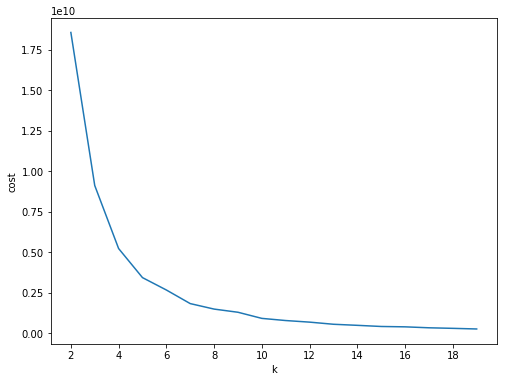

In [45]:
###elbow plot to see the best k
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel("k")
ax.set_ylabel("cost")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [46]:
###k means clustering using the best k
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

kmeans = KMeans() \
          .setK(6) \
          .setFeaturesCol("features")\
          .setPredictionCol("cluster")

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=3).fit(df_recommendation_final)
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(df_recommendation_final)

cluster = model.transform(df_recommendation_final)

In [47]:
cluster.show(10)

+--------------------+--------------------+--------------------+-------+
|            features|          Hotel_Name|     indexedFeatures|cluster|
+--------------------+--------------------+--------------------+-------+
|[6.80748663101604...|Best Western Sera...|[6.80748663101604...|      1|
|[18.3396226415094...|Melia Paris Tour ...|[18.3396226415094...|      1|
|[9.14622057001239...|      Avenida Palace|[9.14622057001239...|      5|
|[7.65459610027855...| H10 Port Vell 4 Sup|[7.65459610027855...|      1|
|[14.0597014925373...|Hyatt Regency Ams...|[14.0597014925373...|      0|
|[12.5233644859813...|H tel Elysees Mermoz|[12.5233644859813...|      1|
|[21.8857142857142...|H tel Barri re Le...|[21.8857142857142...|      4|
|[11.9444444444444...|Melia Paris Notre...|[11.9444444444444...|      4|
|[6.65277777777777...|         HCC Regente|[6.65277777777777...|      0|
|[4.81994459833795...|Grange Holborn Hotel|[4.81994459833795...|      1|
+--------------------+--------------------+--------